In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.version.VERSION)

1.15.0


In [0]:
IMG_SIZE = 512
NUM_IMGS = 10
NUM_CLASSES = 47
task_path = "drive/My Drive/test_task/"
data_path = task_path + "data/"
checkpoints_path = task_path + "checkpoints/"
descr = json.load(open(data_path + "label_descriptions.json", "rb"))
label_names = [cat["name"] for cat in descr["categories"]]

In [0]:
img_name = "00f02bb0dfc890c2944921b59c317ece.jpg" # "00fc1cb8809762f07f6237c96e42ac31.jpg" # 

In [5]:
!git clone https://www.github.com/divamgupta/image-segmentation-keras.git
os.chdir("image-segmentation-keras")

fatal: destination path 'image-segmentation-keras' already exists and is not an empty directory.


In [6]:
from keras_segmentation.models.pspnet import pspnet_50

pspsnet_model = pspnet_50(n_classes=NUM_CLASSES)
pspsnet_model.load_weights(f"../{checkpoints_path}pspnet_model_checkpoint")

Using TensorFlow backend.


In [0]:
def labeled2masked(labeled): 
  # function from Train.ipynb. Converts labeled 2d image to 3d array of masks
  labels = np.unique(labeled)
  labels = labels[labels != 0] # except zero (background)
  rois = list()
  mask = np.zeros((*labeled.shape, len(labels)))
  for i, label in enumerate(labels):
    segment = labeled == label
    mask[:, :, i][segment] = 1

    mask_pos = np.where(segment)
    y1, x1 = np.min(mask_pos, axis=1)
    y2, x2 = np.max(mask_pos, axis=1)

    rois.append([y1, x1, y2, x2])

  return mask, labels, np.array(rois)

def infere_pspnet(img_name, model):
  img = cv2.imread(f"../{data_path}{NUM_IMGS}images/{img_name}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img_name_png = img_name.split('.')[0] + ".png"
  
  out = model.predict_segmentation(
    inp="../" + data_path + "10reshaped/" + img_name_png,
    out_fname="../" + data_path + "results/" + img_name_png
  )
  
  out = cv2.resize(out, 
                  img.shape[1::-1], 
                  interpolation=cv2.INTER_NEAREST)
  
  masks, labels, rois = labeled2masked(out)

  return img, rois, masks, labels - 1

In [8]:
os.chdir("..")
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir("Mask_RCNN")

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [0]:
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn import utils
from mrcnn.config import Config

In [10]:
class FashionConfig(Config):
    NAME = "fashionista"
    NUM_CLASSES = NUM_CLASSES 

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    IMAGE_MIN_DIM = IMG_SIZE
    IMAGE_MAX_DIM = IMG_SIZE 
    STEPS_PER_EPOCH = 500
    
config = FashionConfig()

mrcnn_model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir="")

mrcnn_path = glob.glob(f"../{checkpoints_path}fashionista*/mask_rcnn_fashionista_0001.h5")
if mrcnn_path:
  mrcnn_path = mrcnn_path[0]
  mrcnn_model.load_weights(mrcnn_path, by_name=True)
else:
  print(f"file ../{checkpoints_path}../mask_rcnn_fashionista_0001.h5 not jound")

Re-starting from epoch 1


In [0]:
def infere_mrcnn(img_name, mrcnn_model):
  img = cv2.imread( "../" + data_path + "10images/" + img_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resized_img = cv2.resize(img, 
              (IMG_SIZE, IMG_SIZE), 
              interpolation=cv2.INTER_NEAREST)
  
  r = mrcnn_model.detect([resized_img])[0]

  threshold = 0.9 # just to reduce the mess
  best_segments = r["scores"] > threshold
  r["masks"] = r["masks"][:,:,best_segments]
  r["rois"] = r["rois"][best_segments]
  r["class_ids"] = r["class_ids"][best_segments]
  
  h, w, num_masks = (img.shape[0], img.shape[1], r["masks"].shape[-1])

  masks = np.zeros((h, w, num_masks))
  for m in range(num_masks):
      masks[:, :, m] = cv2.resize(r["masks"][:, :, m].astype("uint8"), 
                                  (w, h), interpolation=cv2.INTER_NEAREST)

  y_scale = h / IMG_SIZE
  x_scale = w / IMG_SIZE
  
  rois = (r["rois"] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
  return img, rois, masks, r["class_ids"] - 1

PSPNet Image segmentation result:

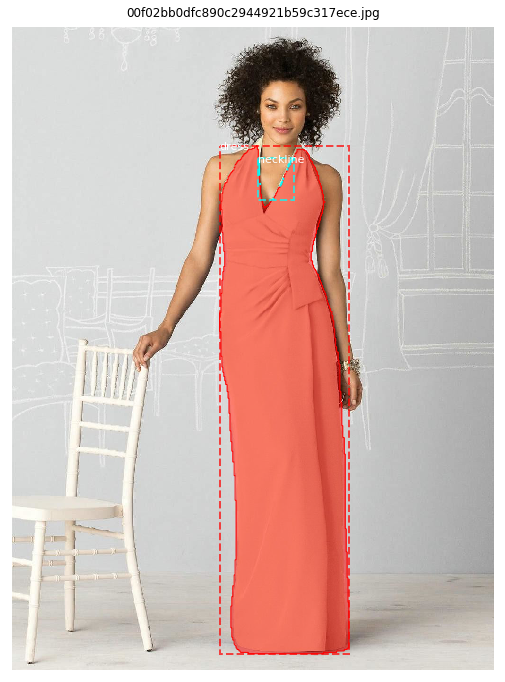

In [12]:
img, rois, masks, class_ids = infere_pspnet(img_name, pspsnet_model)

visualize.display_instances(img, rois, masks, 
                            class_ids, 
                            label_names, 
                            [""] * len(class_ids),
                            title=img_name, 
                            figsize=(12, 12))

Mask RCNN Image segmentation result:

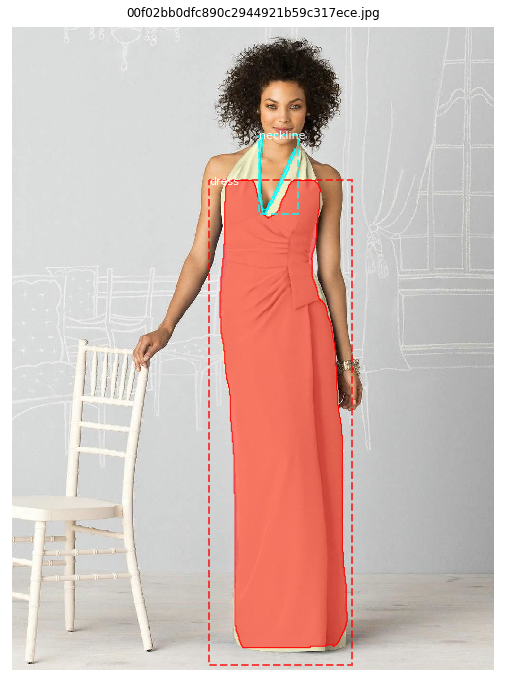

In [15]:
img, rois, masks, class_ids = infere_mrcnn(img_name, mrcnn_model)

visualize.display_instances(img, rois, masks, 
                            class_ids, 
                            label_names, 
                            [""] * len(class_ids),
                            title=img_name, 
                            figsize=(12, 12))